In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
import torch
from torch import nn, optim, utils
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import os
import time
from tqdm import tqdm
import copy

In [2]:
data_dir = '/home/samael/github/image_generation/'
worker = 16
batch_size = 16
image_size = 1024
num_epochs = 10
lr = 1e-3
momentum = 0.9
ngpu = 2

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: vdatasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=worker) for x in ['train', 'val']}
print('Initialized!')

Initializing Datasets and Dataloaders...
Initialized!


In [4]:
device = torch.device('cuda:0')

In [5]:
def norm_image(image):
    min_val = torch.min(image)
    max_val = torch.max(image)
    return (image - min_val) / (max_val - min_val)

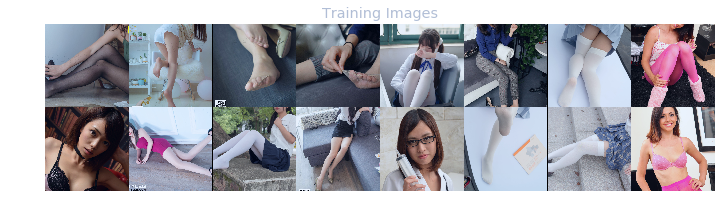

In [6]:
real_batch = next(iter(dataloaders_dict['train']))
val_batch = next(iter(dataloaders_dict['val']))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

In [8]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

In [9]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion)
            )
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [11]:
# resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 7)
# resnet18 = resnet18.to(device)
# if ngpu > 1:
#     resnet18 = nn.DataParallel(resnet18, list(range(ngpu)))

In [12]:
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 7)
resnet34 = resnet34.to(device)
if ngpu > 1:
    resnet34 = nn.DataParallel(resnet34, list(range(ngpu)))

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_correct.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        time_elapsed = time.time() - since
        hour = time_elapsed // 3600
        minute = (time_elapsed - hour * 3600) // 60
        second = (time_elapsed - hour * 3600) % 60
        print("Training elapsed {:.0f}h {:.0f}m {:.0f}s".format(hour, minute, second))
        print()
    
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, train_loss_history, val_acc_history, val_loss_history

In [14]:
optimizer_ft = optim.SGD(resnet34.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [16]:
model_ft, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model(resnet34, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 1.5168 Acc: 0.4019
val Loss: 2.0900 Acc: 0.4046
Training elapsed 0h 4m 23s

Epoch 2/10
----------
train Loss: 1.2568 Acc: 0.5307
val Loss: 1.7175 Acc: 0.4987
Training elapsed 0h 8m 45s

Epoch 3/10
----------
train Loss: 1.1314 Acc: 0.5751
val Loss: 2.2583 Acc: 0.3944
Training elapsed 0h 13m 8s

Epoch 4/10
----------
train Loss: 1.0134 Acc: 0.6208
val Loss: 2.5349 Acc: 0.4122
Training elapsed 0h 17m 32s

Epoch 5/10
----------
train Loss: 0.9412 Acc: 0.6582
val Loss: 2.1161 Acc: 0.5089
Training elapsed 0h 21m 53s

Epoch 6/10
----------
train Loss: 0.8875 Acc: 0.6744
val Loss: 3.9204 Acc: 0.2850
Training elapsed 0h 26m 16s

Epoch 7/10
----------
train Loss: 0.8492 Acc: 0.6849
val Loss: 3.5344 Acc: 0.3715
Training elapsed 0h 30m 41s

Epoch 8/10
----------
train Loss: 0.8242 Acc: 0.7027
val Loss: 3.4885 Acc: 0.4224
Training elapsed 0h 35m 3s

Epoch 9/10
----------
train Loss: 0.7698 Acc: 0.7177
val Loss: 3.0478 Acc: 0.4427
Training elapsed 0h 39m 25s

Epoch

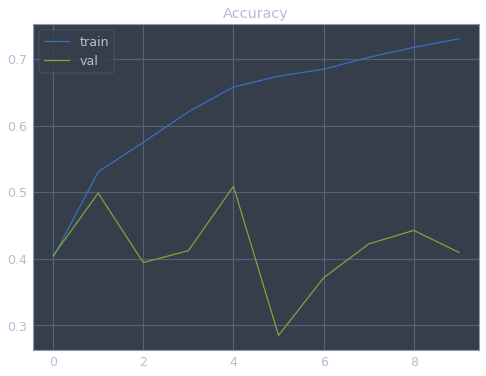

In [17]:
plt.figure(figsize=(8, 6))
plt.title('Accuracy')
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.legend(['train', 'val'])
plt.show()

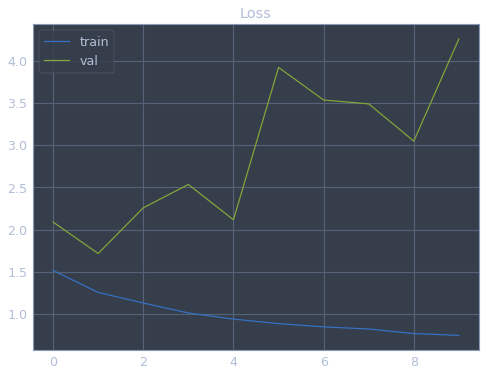

In [18]:
plt.figure(figsize=(8, 6))
plt.title('Loss')
plt.plot(train_loss_hist)
plt.plot(val_loss_hist)
plt.legend(['train', 'val'])
plt.show()

In [19]:
classes = ['black_tights', 'fishnet', 'flesh_colored', 'other_colors', 'others', 'pants', 'white_tights']

In [20]:
train_prob, train_pred = torch.max(F.softmax(resnet34(real_batch[0][:9].to(device)), dim=1), 1)
val_prob, val_pred = torch.max(F.softmax(resnet34(val_batch[0][:9].to(device)), dim=1), 1)

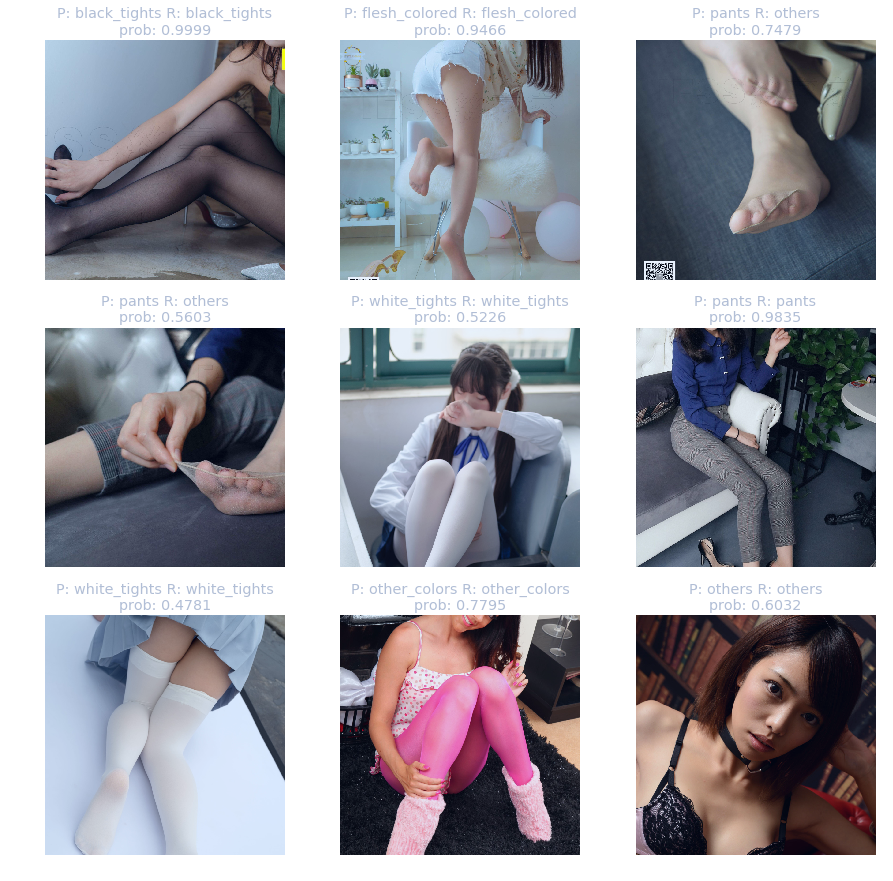

In [21]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: '+classes[train_pred[i]] + " R: " + classes[real_batch[1][i]] + '\n' + 'prob: %.4f' %(train_prob[i]))
    plt.imshow(norm_image(real_batch[0][i]).permute(1, 2, 0))
plt.show()

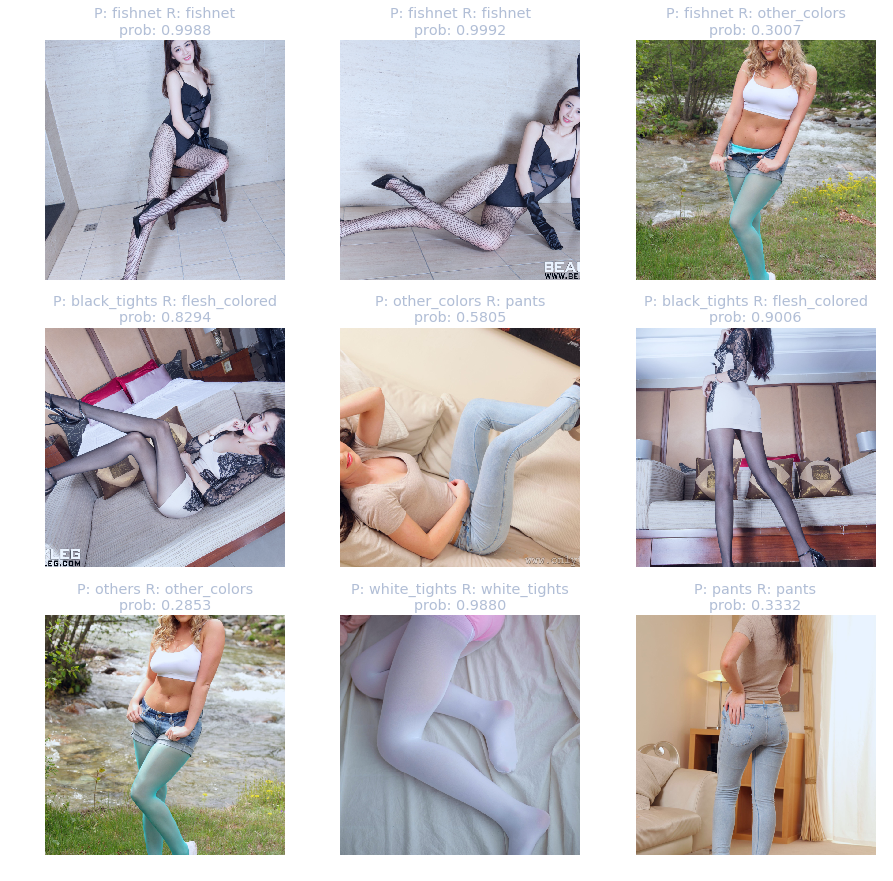

In [22]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: ' + classes[val_pred[i]] + " R: " + classes[val_batch[1][i]] + '\n' + 'prob: %.4f' %(val_prob[i]))
    plt.imshow(norm_image(val_batch[0][i]).permute(1, 2, 0))
plt.show()